In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        if not os.path.isdir(housing_path):
            os.madedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# NOTE: the total_rooms variable is missing a few values. This will be handled later
# Also, the ocean_proximity variable is a python object, lets look into this
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


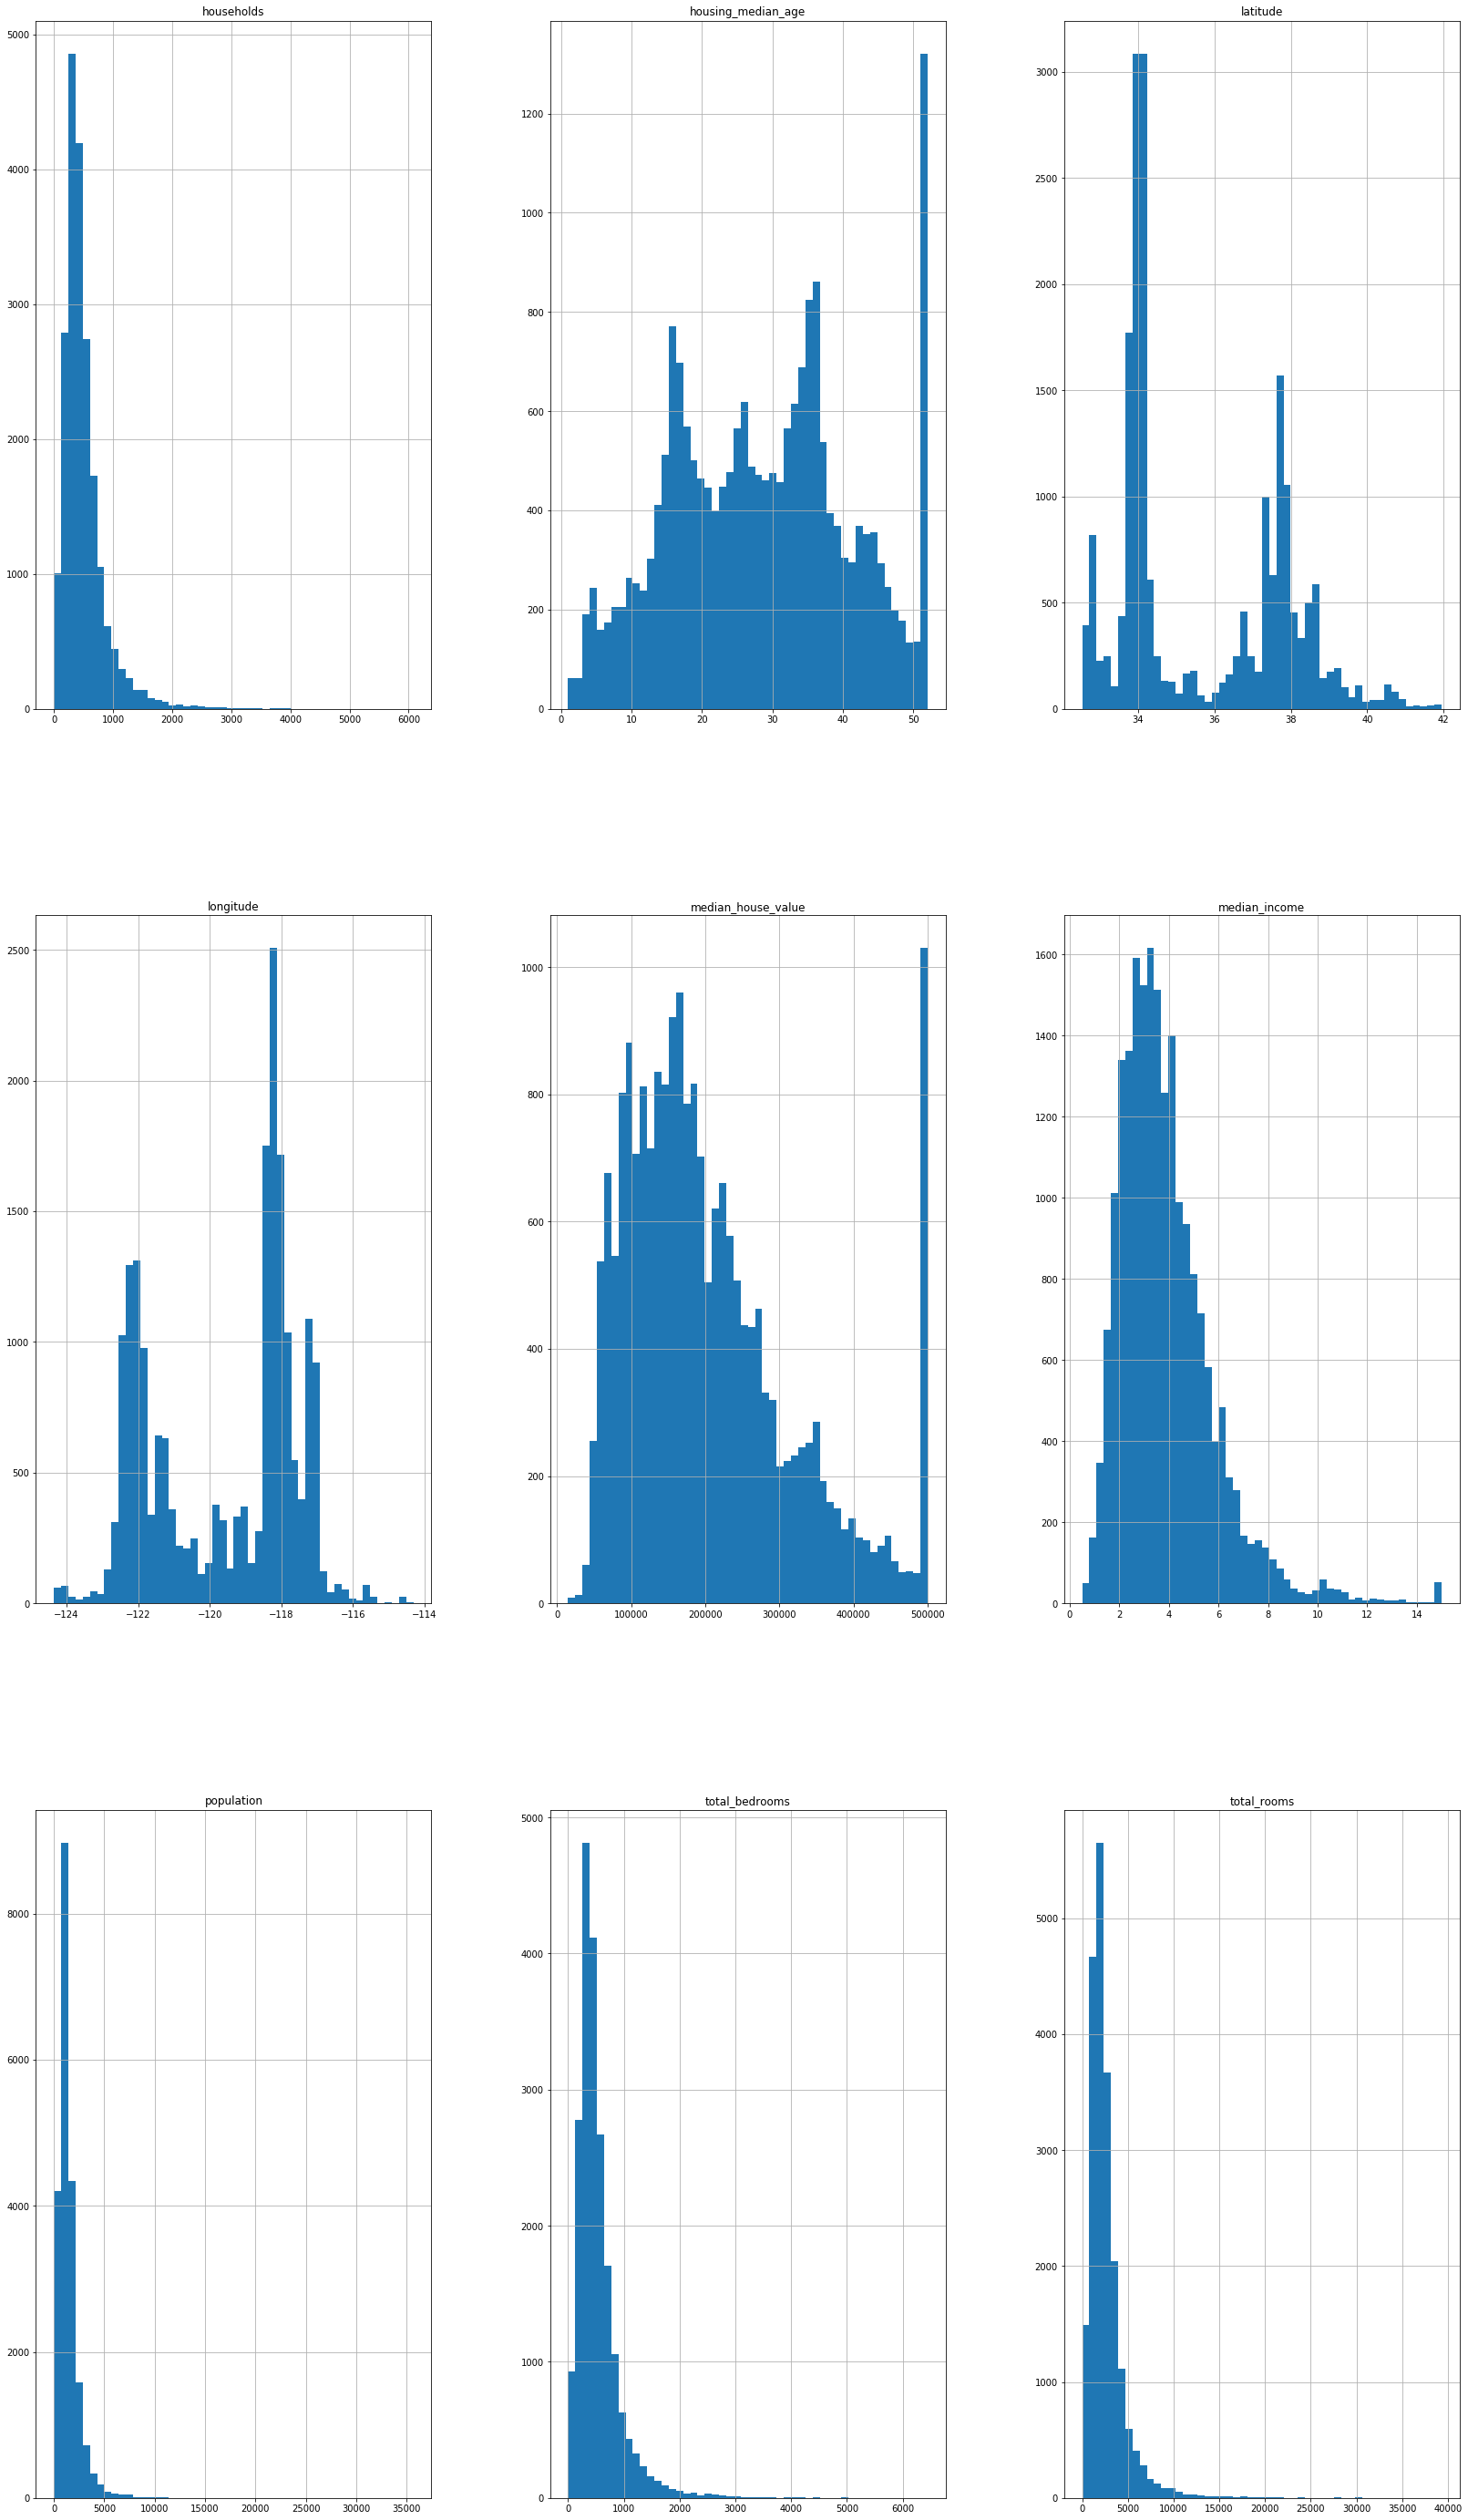

In [7]:
# Create a histogram for each variable in the dataset
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(28, 50))
plt.show()

In [8]:
# Create a test set
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)

In [10]:
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
# To ensure we get the same test set, even after refreshing, use the row index in 'housing' as the key.
housing_with_id = housing.reset_index() # This adds an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
# We will use stable variables as the unique id. Combine long/lat
housing_with_id["id"] = housing['longitude'] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

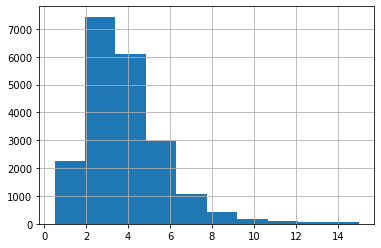

In [17]:
housing["median_income"].hist()

In [18]:
# Create a categorical variable for the median income and ensure it's strata are properly sized and representative
# of the population in question.

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

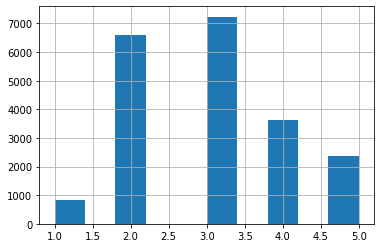

In [19]:
housing["income_cat"].hist()

In [20]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [21]:
# Use stratified sampling on the new income_cat variable using scikit-learn

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [22]:
# Check to see that this variable is properly stratified
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [24]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [25]:
# We'll now remove the income_cat varaiable since it is no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [26]:
# We will now visualize the data

In [27]:
# Create a copy of the training data to play with it
housing = strat_train_set.copy()

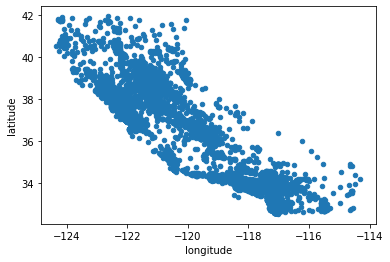

In [28]:
housing.plot(kind='scatter', x='longitude', y='latitude')

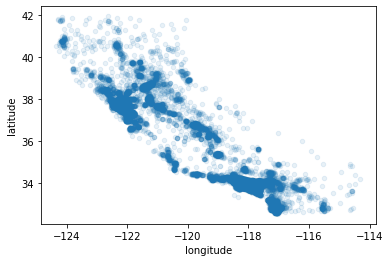

In [29]:
# Create a plot that highlights high density areas
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

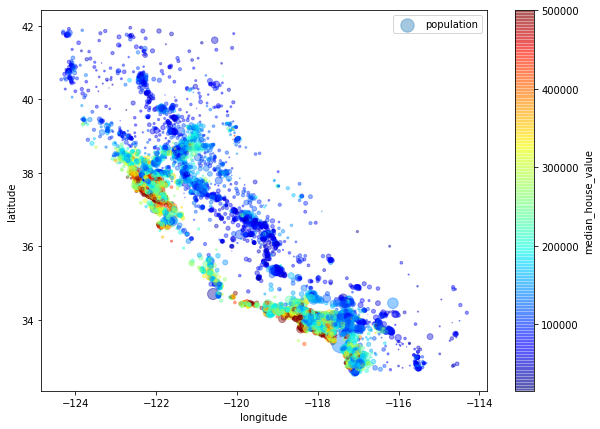

In [30]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()
plt.savefig("housing_prices_scatterplot")

In [32]:
import matplotlib.image as mpimg
california_img=mpimg.imread(r"C:\Users\Matt\.ipynb_checkpoints\Prdicting_House_Prices-checkpoints.ipynb" + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="logitude", y="latitude", figsize=(10,7),
                 s=housing['population']/100, label="Population",
                 c="median_house_value", cmap=plt.get_cmap("jet"),
                 colorbar=False, alpha=0.4,
                 )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Matt\\.ipynb_checkpoints\\Prdicting_House_Prices-checkpoints.ipynb/images/end_to_end_project/california.png'

In [34]:
# Looking for correlations
corr_matrix = housing.corr()

# Lets see how much each attribute correlates with the median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C1C2B28748>,
      dtype=object)

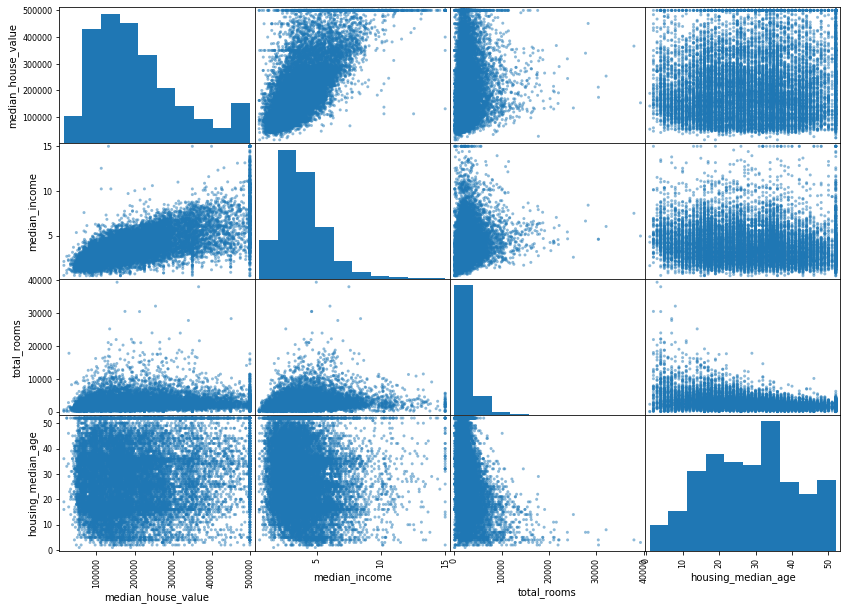

In [35]:
# Use the pandas scatter_matrix() function which plots every numerical attribute against every other numerical attribute.
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(14, 10))

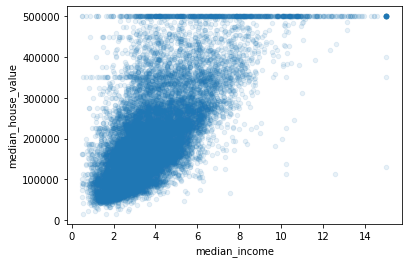

In [36]:
# The median_income attribute looks like it has the strongest realtionship with the med_house_value.
# Lets take a further look at that scatterplot
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

In [37]:
# The scatterplot above shows some horizontal lines around 450,000, another at 350,000, and possibly more.
# We may want to remove the corresponding districts to proevent our algorithms from learning to reproduce these data quirks.

In [38]:
# Before moving on, we should try out various attribute cominations. For example, number of bedrooms in a district is not
# very useful if you don't know how many households there are. What we really want is the number of rooms per household.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/ housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [39]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# PREPARE THE DATA FOR MACHINE LEARNING ALGORITHMS
Reverting to a clean training set by copying strat_train_set and separate thte predictors and the labels, since we don't
necessarily want to apply the same tranformations to the predictors and the target values

In [40]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# DATA CLEANING
Creating some functions for data cleaning
Setting the total_bedrooms missing values to the median

In [41]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [42]:
# Use skleanrs SimpleImputer method
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [43]:
# The imputer has simply computed the median of each attribute and stored the results in its statistics_ instance variable.
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [44]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [45]:
# Use the "trained" imputer to transform the training set by replacing missing values with the learned medians.
X = imputer.transform(housing_num)

In [46]:
# Since the above lined outputed a NumPy array, lets put it back into a Pandas Data Frame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [47]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


The ocean_proximity is a categorical attribute, we will convert the text cats to numbers using sklearn's OrdinalEncoder func

In [48]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [49]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that a ML algorithm will assume two nearby values are more alike than than two distant
values. This is not the case for our ocean_proximity attribute. To fix this, we will one-hot-encode the attribute.
It is named this because only one attribute will be equal to 1 (hot) while the ohthers will be 0(cold).
The new attributes can also be referred to as dummy variables.

In [50]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The above method returned a SciPy sparse matrix. This is useful for when you're working with categorical variables with
thousands of categories. After one-hot-encoding, we get a matrix with thousands of columns, and the matrix is full of
zeros except for a single 1 per row. This is wasteful so the sparse matrix only sotres the location of the nonzero elements. 

In [ ]:
housing_cat_1hot.toarray()

In [52]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
# Developing a custom transformer that will add the combined attributes of interest

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class  CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            if self.add_bedrooms_per_room:
                bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
                return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder =  CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Feature Scaling
Sklearn provides the Pipeline class to help with sequences of transformations.
The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must
be transformers. When the pipeline's fit() method is called, it calls fit_transform() sequentially on all transformers,
passing the output of each cell as the parameter to the next call until it reaches the final estimator, for which it calls
the fit() method.

In [59]:
# Transformation Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we've handled the categorical and numerical columns separately. It would be more convinient to have a single
transformer to handle all columns.
Below, we construc the ColumnTransformer which requires a list of tuples, where each tuple contains 1.) A name
2.) A transformer 3.) A list of names, or indices, of columns that the transformer should be applied to. 

In [60]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)